In [2]:
import rl_util.env_interaction
from rl_util.identity_policy import IdentityLowLevelPolicy
import numpy as np
from rl_utils.analysis import reps_solve_info_analysis  
from scipy.stats import norm
import pickle
import pydmps
import matplotlib.pyplot as plt
import delta_array_utils.RealDeltaControl as RDC
# import manip_utils.SimDeltaControl as SDC

In [3]:
with open("./data/sim/skill2/1.pkl", "rb") as f:
    reps_policy_loaded = pickle.load(f)

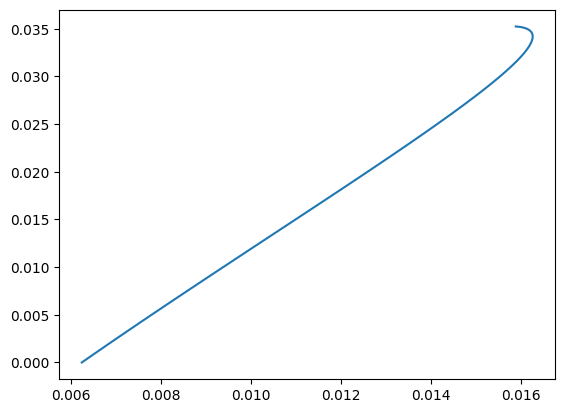

In [4]:
mean = reps_policy_loaded['low_level_policy_params_mean']
covar = reps_policy_loaded['low_level_policy_params_var']
time_horizon = 101

def Bezier_Curve(t, p1, p2, p3, p4):
    return (1-t)**3*p1 + 3*t*(1-t)**2*p2 + 3*t**2*(1-t)*p3 + t**3*p4

def DMP_trajectory(curve):
    DMP = pydmps.dmp_discrete.DMPs_discrete(n_dmps=2, n_bfs=200, ay=np.ones(2) * 10.0)
    y_track = []
    dy_track = []
    ddy_track = []

    DMP.imitate_path(y_des=curve)
    trajectory, _, _ = DMP.rollout(tau=1)
    return trajectory

for i in range(1):
    action = np.random.multivariate_normal(mean=mean,cov=covar)
    x1, y1 = (action[0] + 1)/2*0.02 + 0, (action[1] + 1)/2*0.05 + 0
    x2, y2 = (action[2] + 1)/2*0.02 + 0, (action[3] + 1)/2*0.05 + 0
    x3, y3 = (action[4] + 1)/2*0.015 + 0.01, (action[5] + 1)/2*0.06 + 0.01
    prev_y1, prev_y2 = pickle.load(open("./data/skill1_vars.pkl", "rb"))

    """ Generate Bezier curve trajectory using REPS variables and smoothen trajectory using DMP """
    points = np.array(((prev_y1, 0), (x1, y1), (x2, y2), (x3, y3)))
    # print(points)
    curve = np.array([Bezier_Curve(t, *points) for t in np.linspace(0, 1, time_horizon - 1)]).T
    skill_traj = DMP_trajectory(curve)
    skill_hold_traj = np.linspace([0, 0], [prev_y2, 0], time_horizon - 1)

    # print(np.min(skill_traj[:,0]),np.max(skill_traj[:,0]),np.min(skill_traj[:,1]),np.max(skill_traj[:,1]))
    plt.plot(curve[0], curve[1])

In [7]:
with open("./data/trajs/curve.pkl", "wb") as f:
    pickle.dump(curve, f)

In [67]:
class DMP:
    def __init__(self, num_bfs = 16):
        self.num_bfs = num_bfs     # num of basis functions
        self.K = 25*25/4     # Spring coefficient
        self.B = 25          # damper coefficient
        self.C = np.linspace(0, 1, self.num_bfs)    # num of basis fn centers
        self.H = 0.65*(1/(self.num_bfs - 1))**2      # bf widths
        
        self.weights = [0, 0, 0, 0, 0]
        self.start = self.goal = self.T = 0
        self.q = self.qd = self.qdd = 0
        
    def set_task_params(self, start, goal, T, dt):
        self.dt = dt
        self.start = start
        self.goal = goal
        self.T = T
        self.q = self.start
        self.qd = self.qdd = 0
        
    def fwd_simulate(self, horizon, weights):
        t = 0
        pos = []
        for i in range(horizon):
            t += self.dt
            if t <= self.T:
                phi = [np.exp(-((t/self.T - c)**2)/2*self.H) for c in self.C]
                phi /= np.sum(phi)
#                 print(phi)
                f = np.dot(phi, weights)
            else:
                f = 0
#             print(f)
            self.qdd = (self.K*(self.goal-self.q)/(self.T**2)) - self.B*self.qd/self.T + (self.goal-self.start)*f/(self.T**2)
#             print(self.qdd)
            self.qd += self.qdd * self.dt
            self.q += self.qd * self.dt
            pos.append(self.q)
        return np.array(pos)

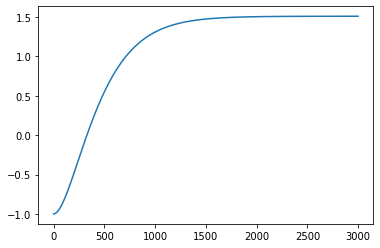

In [70]:
dmp = DMP()
dmp.set_task_params(-1, 1.5, 3, 0.001)
pos = dmp.fwd_simulate(3000, np.random.rand(16))
plt.plot(pos)

In [83]:
np.linalg.norm(np.vstack((x_pos, y_pos)) - curve)

0.12079191238496917

0.11346535604427481


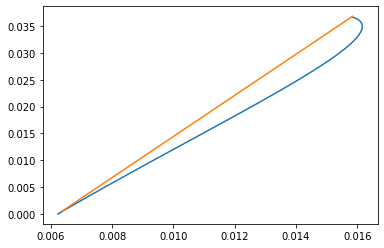

In [95]:
x_dmp = DMP(num_bfs = 16)
y_dmp = DMP(num_bfs = 16)
xs, ys = curve
x_dmp.set_task_params(xs[0], xs[-1], 3, 0.03)
x_pos = x_dmp.fwd_simulate(100, np.random.rand(16))

y_dmp.set_task_params(ys[0], ys[-1], 3, 0.03)
y_pos = y_dmp.fwd_simulate(100, np.random.rand(16))

print(np.linalg.norm(np.vstack((x_pos, y_pos)) - curve))

plt.plot(curve[0], curve[1])
plt.plot(x_pos, y_pos)

In [98]:
""" LET'S TRY TO MAKE THE ORANGE CURVE SAME AS BLUE """
import torch
import torch.nn as nn
import torch.nn.functional as F

# EXPERIMENT 1
"""
Input: start block pose, target block pose : np.array((0.0433, 0.033, 0 | 0.0433, 0.04, np.pi/12) )
Output: weights of basis functions on all degrees of freedom to get desired trajectory
"""

class NDMP(nn.Module):
    def __init__(self, num_bfs = 16):
        super(NDMP, self).__init__()
        self.num_bfs = num_bfs
        self.ndmp_model = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_bfs * 2)
        )
    
    def forward(self, x):
        output = self.ndmp_model(x)
        return output

In [99]:
dmp_model = NDMP()
criterion = nn.MSELoss()
learning_rate = 0.001
epochs = 10    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dmp_model = dmp_model.to(device)

In [103]:
optimizer = torch.optim.Adam(dmp_model.parameters(), lr = learning_rate)
ip = torch.Tensor([0.0433, 0.033, 0, 0.0433, 0.04, np.pi/12]).to(device)

x_dmp = DMP(num_bfs = 16)
y_dmp = DMP(num_bfs = 16)
xs, ys = curve
x_dmp.set_task_params(xs[0], xs[-1], 3, 0.03)

y_dmp.set_task_params(xs[0], xs[-1], 3, 0.03)

for epoch in range(epochs):
    optimizer.zero_grad()
    output = dmp_model(ip)
    output_clone = loss.clone().detach().numpy()
    x_wts = output_clone[:16]
    y_wts = output_clone[16:]
    x_pos = x_dmp.fwd_simulate(100, np.random.rand(16))
    y_pos = y_dmp.fwd_simulate(100, np.random.rand(16))
    loss = criterion(torch.from_numpy(np.vstack((x_pos, y_pos))), torch.from_numpy(curve))
    loss.backward()
    print(f"Epoch: {epoch}, Loss: {loss}")
    optimizer.step()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
action

In [7]:
env = SDC.DeltaRobotEnv('./config/env.yaml',"skill1")
env.reset()

Physics Engine: FleX
Physics Device: cuda:0
GPU Pipeline: disabled


MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0



In [4]:
while True:
    action = np.random.multivariate_normal(mean=mean,cov=covar)
    env.step(action)
    env.reset()

NameError: name 'env' is not defined